# Exploring Convolutional Network Shapes with Keras

This notebook creates a convolutional neural network for image classification. We use this network to illustrate how steps in a convolutional neural network affect the shape of the data. The convolutional neural network example in this notebook comes from the [keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and covers an example of classifying images of cats and dogs.

## Imports

This notebook will set up a simple convolutional neural network and use sample images of cats and dogs. (The hypothetical task would be a classifier that could identify dogs or cats in the object.)

In [58]:
# Use the ImageDataGenerator to apply transformations to images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [59]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

## Image Data

Let's start by exploring the image data we have. We'll look at a cat photo first:

In [61]:
img = load_img('train/data/cat.1.jpg')
x = img_to_array(img)
print(x.shape)

(280, 300, 3)


The dimensionality of the image is $280 \times 300$, and there are an additional 3 copies of the image (the red, blue, and green channels). When the image is converted to an array, it is a 2D array of values between 0 and 255. Here is the vector value of one particular pixel's three color channels:

In [62]:
x[0][0]

array([39., 44., 40.], dtype=float32)

In [63]:
print(np.max(x))
print(np.min(x))

255.0
0.0


 We can visualize each channel independently by using matplotlib's `imshow()` function to convert the array of numbers into an image:

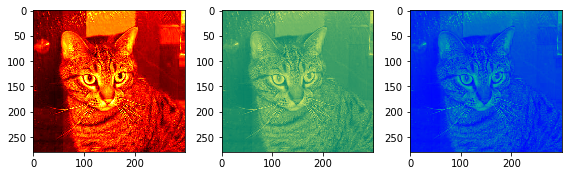

In [64]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(8,15))
ax1.imshow(x[:,:,0], cmap=plt.get_cmap('hot'))
ax2.imshow(x[:,:,1], cmap=plt.get_cmap('summer'))
ax3.imshow(x[:,:,2], cmap=plt.get_cmap('winter'))
fig.tight_layout()
plt.show()

## Create Convolutional Neural Network

Now we'll create the layers of the convolutional neural network and assemble them into a model that is ready to be trained on data. 

The network we will build in this notebook follows the [keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html):

* Convolution (3x3 kernel, 32 filters)
* Activation (ReLU)
* Max Pooling (2x2)
* Convolution (3x3 kernel, 32 filters)
* Activation (ReLU)
* Max Pooling (2x2)
* Convolution (3x3 kernel, 64 filters)
* Activation (ReLU)
* Max Pooling (2x2)
* Flatten
* Dense
* Activation (ReLU)
* Dropout (0.5)
* Dense
* Activation (sigmoid)

First, we set some parameters:

In [65]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'train'
validation_data_dir = 'validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 1
batch_size = 50

In [66]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

The architecture for this neural network is three convolutional layers, two with 32 filters and one with 64 filters, followed by a flatten/dense/activation/dropout combination.

In [67]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
metrics=['accuracy'])

To get more details about what each layer is doing, we can use the built-in `summary()` method of the Keras model. This will give us information about the output shapes of each layer and the number of parameters that each layer has.

In [68]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_21 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 64)        18496     
__________

In [69]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

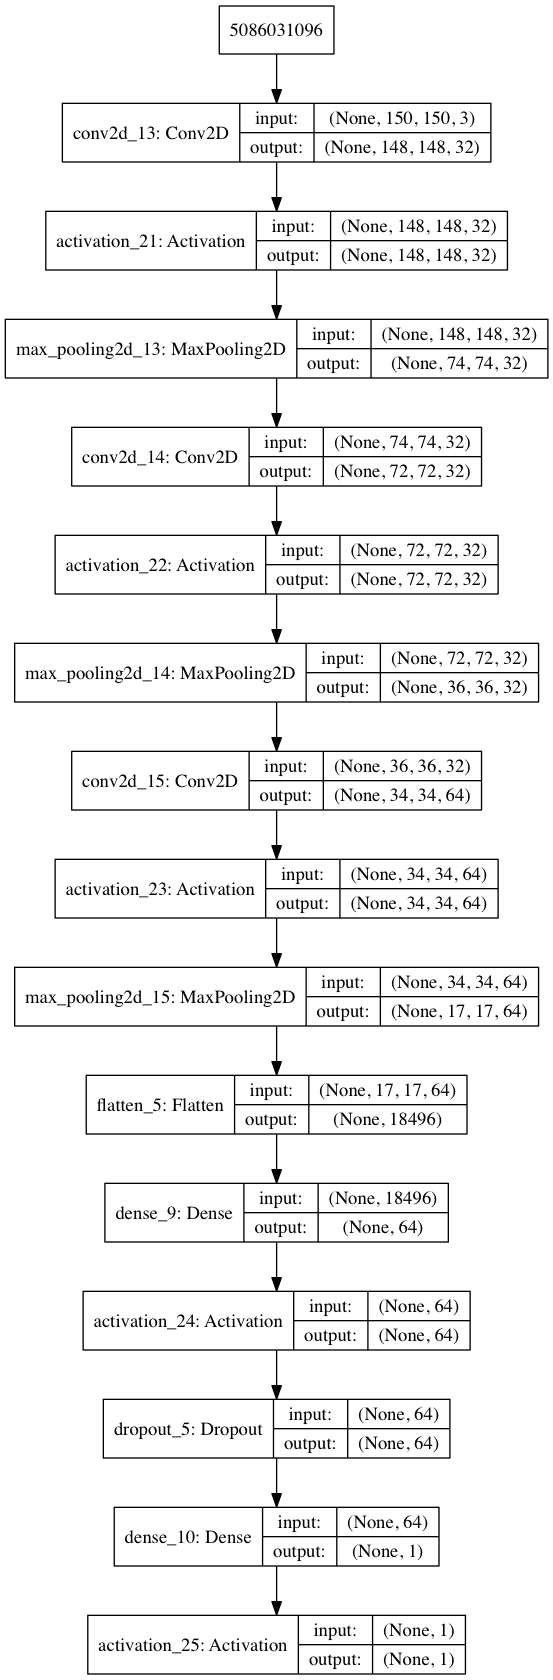

In [70]:
Image('model_plot.png')

## Network Architecture/Shapes

Above, we have created our convolutional neural network and made some assumptions about the (image) input data Let's examine in more detail how each of these layers affects the shape and where the number of parameters comes from.

### Input Image Layer

We start with the input layer, which takes images of size $m \times n = 150 \times 150$. We have color images so we also have 3 color channels. The shape of the input layer is therefore $(150, 150, 3)$. 

We will need to create an image transformer that will adjust the size of images being fed to the neural network, since we have some not-quite-square images.

### First Convolution Layer

Once we have sized an image correctly, we have an image with dimensions $(m,n,3)$. The convolution layer applies a convolution kernel to the entire image; the entire $m \times n$ image is covered with a window of size $k \times k$, which leads to an image of size $(m - k + 1, n - k + 1)$.

If we specify that the convolution layer should have $c$ output filters, we will get an output from the first convolution layer that has dimensions $(m-k+1, n-k+1, c)$. Each convolution kernel (which is learned from the data by the model) is the same for the entire image. However, each color channel has its own kernel associated with it. Images with 3 color channels will have 3 kernel functions to learn per image.

In terms of the concrete example, we have an image of size $150 \times 150$ and our first convolution layer uses a kernel window of size $3 \times 3$, for a final output image of size $(150 - 3 + 1, 150 - 3 + 1) = (148, 148)$.

The convolution layer was specified to use 32 filters, so the final dimensionality of the data leaving the first convolution layer is $(148, 148, 32)$.

This layer has 896 parameters that the model learns. This number comes from having one 3x3 kernel (9), per color channel (3), per convolution filter (32), for a total of $9 \times 3 \times 32 = 864$. In addition, there are 32 more weights, for a total of 896.

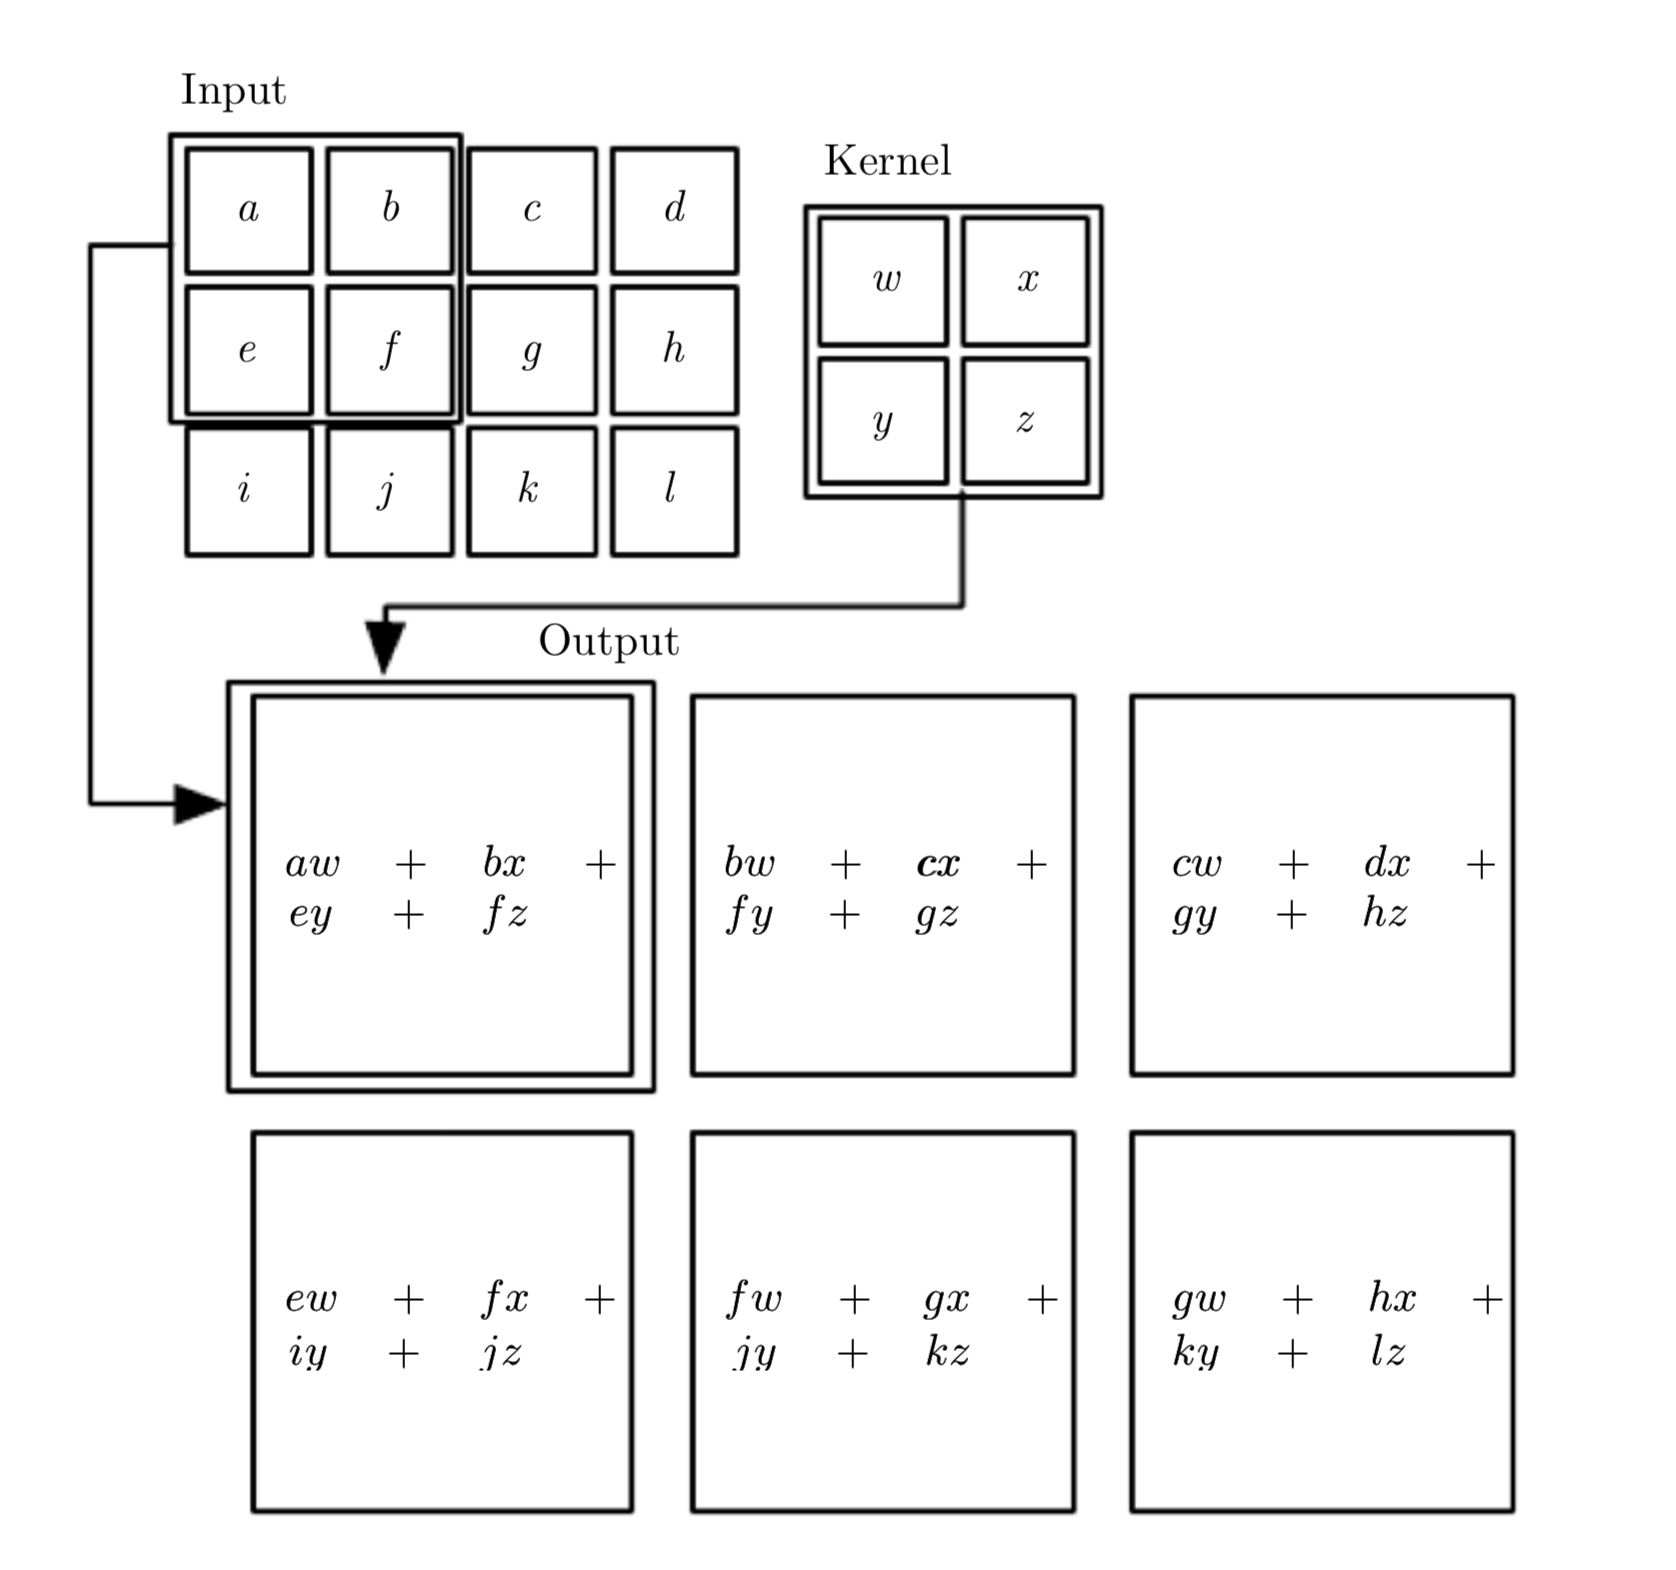

In [83]:
# Source:
# Book "Deep Learning" (Ian Goodfellow, Yoshua Bengio, Aaron Courville)

Image('img/input_kernel_output.png', width=600)

**Sidebar: What happened to the color channel information?**

First, let's revisit (mathematical) definition of convolution:

$$
g(x) = \int f(x) w(x) dx
$$

where $f(x)$ is a function that is an input to the convolution process, $g(x)$ is a function that is the output of the convolution process (the "feature map"), and $w(x)$ is a weight function (a convolution kernel).

The discrete form of the convolution is the summation:

$$
g_j^n = \sum_{k=0}^{K=3} f_{k}^{n-1} w_{kj}^{n}
$$

where $g$ is the output feature map, $f$ is the input to the layer, and $w$ is the kernel function; and the subscript $k$ indexes which color channel, $n$ indexes which layer, and $j$ indexes which feature map.

From the summation above, we can see that the output of the convolution from each of the three color channels are combined additively. Each of the feature maps combines information from all three color channels.

While it seems like we would lose information about the contributions of different color channels by adding together each channel's contribution to the feature map, we actually have separate kernel functions for each color channel, and those kernel functions are learned, so contributions from different color channels are weighted differently based on the learned kernel.

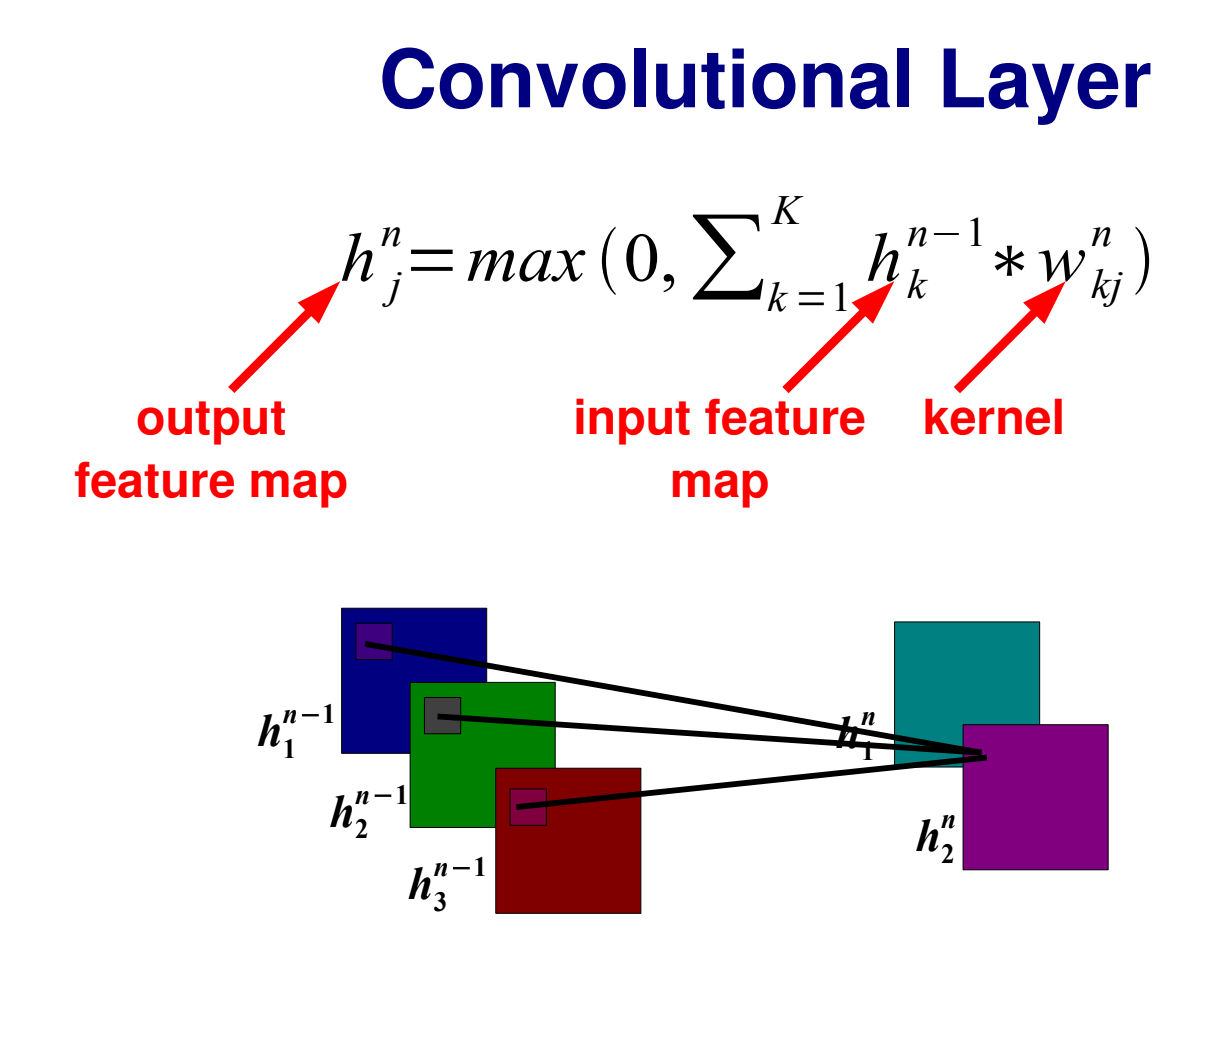

In [82]:
# Source:
# "Large-Scale Visual Recognition" (presentation by Marc'Aurelio Ranzato, Facebook AI Research)
# https://tinyurl.com/y5xtvhbc

Image('img/conv_channels.png',width=500)

### First Activation Layer

After the input data passes through the convolution layer, it now has dimensionality $(148, 148, 32)$.

The activation layer translates the linear operations occurring in the convolution layer (the summation shown above) into a nonlinear output signal.

The example above uses the ReLU function (rectified linear unit), which is the function:

$$
f(x_i) = \max(0, x_i)
$$

These activation function layers are functional mappings without any parameters to set.

**Sidebar: Why use ReLU? What are the other options?** 

Rectified linear units are recommended in the literature for convolutional neural networks because they don't introduce strong non-linearities, and they can avoid some problems with larger networks with training slowing down or completely stopping (see the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)).

Before ReLU units were common in convolutional neural networks, the tanh and sigmoid functions were popular. These suffer from the vanishing gradient problem. Gradient here refers to the gradient of the error function with respect to a particular weight in the network. These gradients are multiplied together as we move backwards through a network to reach the particular weight in the network, which is used to update the weight's value. However, the gradient of the tanh and sigmoid functions take on values between 0 and 1, and due to back-propagation, the gradients are multiplied together, causing their values to vanish. A zero gradient value will prevent a weight in the network from updating.

### First Pooling Layer

Each of the convolution steps in this network use max pooling. The max pooling step allows the network to become insensitive to the exact location of the features the network is learning to identify. The max pooling step can also be thought of as a "blurring" of the filters that result from the convolution and activation layers. It does this by dividing the entire image into square regions, and then taking the maximum value in those square regions.

The pooling layer in the example above is applied with a 2x2 window. With a 2x2 window the stride is also 2, so the size of the original filter is cut in half by the max pooling layer. The dimensions of the 148 square are cut in half, 148 / 2 = 74, resulting in a 74 x 74 block.

The dimensionality of the data leaving the first max pooling layer is $(74,74,32)$.

Like the activation layers, the max pooling layers do not have any parameters.

### Second Convolution Layer

The second convolutional layer takes the result of the prior max pooling layer as an input. When this layer is created, a number of convolutional filters must be specified. We denote this $c_2$ (for number of convolutional filters for the second group of convolutional layers).

Like the prior convolution layer, we are starting with data of dimensions $(m_1, n_1, c)$ (where $m_1, n_1$ is the width, height of the output of the first convolutional layers, c is the number of filters from the prior convolutional layer). The convolution layer applies a convolution kernel of size $k \times k$ (it does not have to be same size as kernel applied in prior convolution layers, we just continue using $k$ for convenience).

The dimensionality of the convolution result will be $(m_1 - k + 1, n_1 - k + 1, c_2)$.

In our specific example, the input dimensionality (output from the first convlutional layers) was $(74, 74, 32)$. 

The kernel window we use is $3 \times 3$ ($k = 3$, the same as the prior convolutional layers). The number of output filters is $c_2 = 32$. This makes the output dimensionality of the 2D convolution layer $(72, 72, 32)$.

**Sidebar: What happened to color channel information in the second convolution layer?** We already saw how color channel information (third dimension) was treated - each color channel had its own kernel that was learned by the model, and in the end the output filters are an additive contribution from the separate convolution of each of the three channels.

In a similar manner, the 32 output filters from the first convolutional layers can be thought of as 32 "channels" that similarly each have their own kernel function that is learned (different for each of the 32 channels), and that each contribute additively to the final convolution filter.

The number of parameters in this layer is 9248. This number comes from having one 3 x 3 kernel (9 parameters), per channel (x32), per convolution filter (x32), for a total of $9 \times 32 \times 32 = 9216$. Additionally there are 32 more weights (one per output filter), for a total of 9248.

### Second Activation Layer

The second activation layer maps input values to output values. The second activation layer uses the ReLU function (rectified linear unit). This is the same activation function used in the first activation layer.

The activation layer maps a single input value to a single output value, so there is no change in dimensionality in this layer. The input dimensionality is $(72, 72, 32)$ and the output dimensionality is $(72, 72, 32)$.

### Second Max Pooling Layer

The second max pooling layer works the same way as the first - the output filters are divided into squares of size 2 x 2 and the final value that represents the square is the maximum value in that square. This divides the dimensions of each filter in half.

72/2 = 36 so the input dimensionality is $(72, 72, 32)$ and the output dimensionality is $(36, 36, 32)$.

### Third Convolution Layer

The third convolution layer has an input dimensionality that is the same as the prior layer, $(36, 36, 32)$.

The third convolution layer applies a kernel of size $3 \times 3$ and has 64 filters (twice the number of the prior two layers).

The output dimensionality is therefore $(36 - 3 + 1, 36 - 3 + 1, 64) = (34, 34, 64)$.

The number of parameters in the third layer is 18496. This comes from having one 3 x 3 filter (9 parameters), per (input) channel (x32), per (output) convolution filter (x64), for a total of $9 \times 32 \times 64 = 18432$ plus an additional 64 parameters (due to the 64 filterS), for a total of $18432 + 64 = 18496$.

### Third Activation Layer

The third activation layer is identical to the first and second - it uses the ReLU function to perform a nonlinear mapping of inputs to outputs. This layer does not change the dimensionality, so the input and output dimensionality are both $(34, 34, 64)$.

This layer does not have any parameters.

### Third Max Pooling Layer

Like the first two max pooling layers, the third max pooling layer uses windows of size 2 x 2 to perform pooling. The first two input dimensions are cut in half, so the input dimensionality is $(34, 34, 64)$ and the output dimensionality is $(17, 17, 64)$.

This layer does not have any parameters.

### Flatten

The flatten layer flattens the multidimensional output of the prior layer to a single dimension. The input dimensionality is $(17, 17, 64)$ and the output dimensionality is $(17 \times 17 \times 64, 1) = (18496,1)$.

This layer does not have any parameters, because it is only reshaping the outputs of the prior layer.

### Dense (64)

Now we create a dense connection between the prior 18496 neurons and a flat layer of 64 neurons, leading to $(18496 \times 64) + 64 = 1,183,744 + 64 = 1,183,808$ individual weights (parameters to be fit).

### Dense (1)

Now we create a dense connection between the flat layer of 64 neurons and a flat layer of 1 neuron, leading to $(64 \times 1) + 1 = 64 + 1 = 65$ individual weights (parameters to be fit).

## Image Transformer

Not all of the images are the correct size (the image above was 280 x 300 instead of the 150 x 150 image our CNN model expects). To deal with this, we can use an `ImageDataGenerator` object to generate data from a folder full of images. The `ImageDataGenerator` also allows us to specify a target image size.

We can also add parameters to the `ImageDataGenerator` that allows us to generate multiple training images from a single image, via transformations - sharing, zooming, and horizontally flipping. This also helps to keep the model flexible in its ability to recognize particular shapes unique to cats or dogs.

In [71]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [72]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 20 images belonging to 1 classes.


In [73]:
validation_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 9 images belonging to 1 classes.


In [74]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/1
40/40 [==============================] - 31s 768ms/step - loss: 0.0180 - acc: 0.9850 - val_loss: 1.0000e-07 - val_acc: 1.0000


In [75]:
model.save_weights('first_try.h5')